In [ ]:
import pandas as pd
import geopandas as gpd

1. Obtener ubicaciones - cuando los pagos fueron realizados por Diego
2. Obtener correos electrónicos de transacciones, a partir del 2025-01-01
3. Obtener transacciones de Splitwise, incluir las transacciones eliminadas, pero mantener solo las más recientes con el mismo precio y descripción/hash.
   Conservar solo las creadas por Diego.

Cómo asociar transacciones con gastos
1. Muy fácil: usar los campos hash. Asumir que las transacciones eliminadas significan "gasto personal"
2. Asociar transacciones por día y con montos similares. Podemos asumir que cualquier transacción que no esté en Splitwise puede ser personal.

Estudiar:
1. ¿Existe alguna relación entre la descripción y el comerciante de la transacción? Es decir, ¿podemos crear una mejor descripción a partir del comerciante?
2. ¿Cuál es la relación entre las ubicaciones y los gastos? Cuánto aporta en predecir que es un gasto personal/compartido?

In [107]:
def clean_datetime_serie(serie: pd.Series, timezone="America/Santiago") -> pd.Series:
    """
    Cleans a datetime column by converting it to a standard format.
    """
    new = pd.to_datetime(
        serie, format="ISO8601", utc=True, errors="coerce"
    ).dt.tz_convert(timezone)
    return new

<Axes: >

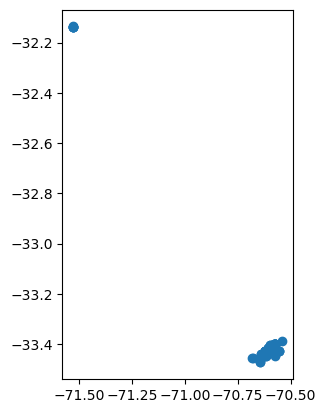

In [108]:
def read_locations(file_name: str) -> gpd.GeoDataFrame:
    assert file_name.endswith(".jsonl"), "File must be a JSON Lines file"
    df = pd.read_json(file_name, lines=True)
    df["date"] = clean_datetime_serie(df["date"])

    gdf = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df["lon"], df["lat"]),
        crs="EPSG:4326",
    )
    return gdf


locations = read_locations("raw/locations.jsonl")
locations.plot()

In [177]:
from typing import Optional

EXPENSES_CLEANED_COLUMNS = [
    "id",
    "date",
    "category_name",
    "description",
    "cost",
    "details",
    "created_at",
    "updated_at",
    "deleted_at",
    "created_by_name",
    "updated_by_name",
    "deleted_by_name",
]


def is_duplicated_expense(expenses: pd.DataFrame) -> pd.Series:
    # Un expense se considera duplicado si tiene la misma fecha, costo y descripción
    # Marcaremos como duplicados a los que tienen una fecha de deleted_at no nula (que fueron eliminados)
    duplicated = (
        expenses.groupby(["date", "cost", "description"])
        .agg(cnt=("id", "count"), ids=("id", list))
        .pipe(lambda df: df[df.cnt > 1])
    )
    duplicated_ids = duplicated["ids"].explode().unique()
    is_duplicated = expenses["id"].isin(duplicated_ids) & ~expenses["deleted_at"].isna()
    return is_duplicated


def read_expenses(
    file_name: str,
    keep_all_columns: Optional[bool] = False,
    keep_duplicated: Optional[bool] = False,
) -> pd.DataFrame:
    assert file_name.endswith(".json"), "File must be a JSON file"

    df = pd.read_json(file_name)
    for col in ["date", "created_at", "updated_at", "deleted_at"]:
        df[col] = clean_datetime_serie(df[col])

    for col in ["created_by", "updated_by", "deleted_by"]:
        df[f"{col}_id"] = df[col].str["id"]
        df[f"{col}_name"] = df[col].str["first_name"]

    df["category_id"] = df["category"].str["id"]
    df["category_name"] = df["category"].str["name"]

    if not keep_all_columns:
        df = df[EXPENSES_CLEANED_COLUMNS]

    is_duplicated = is_duplicated_expense(df)
    if keep_duplicated:
        df["is_duplicated"] = is_duplicated
    else:
        df = df[~is_duplicated]

    df = df.rename(columns=lambda x: f"expense_{x}")
    return df


expenses = read_expenses("raw/expenses.json", keep_all_columns=False)
expenses

,expense_id,expense_date,expense_category_name,expense_description,expense_cost,expense_details,expense_created_at,expense_updated_at,expense_deleted_at,expense_created_by_name,expense_updated_by_name,expense_deleted_by_name
0,3767480899,2025-04-23 19:16:00-04:00,General,SEBASTIAN SANTIAGO CHL,5980.0,una compra por $5.980 con Tarjeta de Crédito *...,2025-04-23 19:20:05-04:00,2025-04-23 19:20:05-04:00,NaT,Diego,None,None
1,3767480895,2025-04-23 19:11:00-04:00,General,RESTAURANTE EL HUERTO SANTIAGO CHL,31460.0,una compra por $31.460 con Tarjeta de Crédito ...,2025-04-23 19:20:04-04:00,2025-04-23 19:20:04-04:00,NaT,Diego,None,None
2,3767403107,2025-04-23 17:36:00-04:00,General,MERCADOPAGO *QUIPUSAL Las Condes CHL,55000.0,una compra por $55.000 con Tarjeta de Crédito ...,2025-04-23 17:40:05-04:00,2025-04-23 18:04:41-04:00,2025-04-23 18:04:41-04:00,Diego,None,Diego
3,3767229458,2025-04-23 15:07:00-04:00,General,SPID MUT - O871 SANTIAGO CHL,1190.0,una compra por $1.190 con Tarjeta de Crédito *...,2025-04-23 15:10:04-04:00,2025-04-23 15:25:37-04:00,2025-04-23 15:25:37-04:00,Diego,None,Diego
4,3767229442,2025-04-23 15:05:00-04:00,General,HAULMER*CEVICHERIA AL SANTIAGO CHL,8500.0,una compra por $8.500 con Tarjeta de Crédito *...,2025-04-23 15:10:04-04:00,2025-04-23 15:25:30-04:00,2025-04-23 15:25:30-04:00,Diego,None,Diego
...,...,...,...,...,...,...,...,...,...,...,...,...
995,3221560784,2024-06-29 21:13:00-04:00,Groceries,Paumar,4490.0,None,2024-07-04 21:14:09-04:00,2024-07-04 22:40:48-04:00,NaT,Daniela,Daniela,None
996,3221560460,2024-06-29 21:13:00-04:00,Groceries,Verduras,1680.0,None,2024-07-04 21:13:35-04:00,2024-07-04 21:13:35-04:00,NaT,Daniela,None,None
997,3210244911,2024-06-29 18:04:33-04:00,Utilities - Other,Dinero en efectivo,30000.0,None,2024-06-29 18:05:05-04:00,2024-06-29 18:05:05-04:00,NaT,Diego,None,None
998,3209983335,2024-06-29 15:03:07-04:00,Dining out,Rienda suelta bar,25980.0,None,2024-06-29 15:03:28-04:00,2024-06-29 15:03:52-04:00,NaT,Diego,Diego,None


In [178]:
from functools import reduce
from typing import Callable


def apply_transforms(
    df: pd.DataFrame, transforms: Callable[pd.DataFrame, pd.DataFrame]
) -> pd.DataFrame:
    df = reduce(
        lambda df, transform: transform(df),
        transforms,
        df,
    )
    return df

In [179]:
def expand_dict_column(column_name: str) -> pd.DataFrame:
    def inner(df: pd.DataFrame) -> pd.DataFrame:
        fill_na_values = lambda x: x if isinstance(x, dict) else {}
        df[column_name] = df[column_name].apply(fill_na_values)
        frame = (
            df[column_name]
            .apply(pd.Series)
            .rename(columns=lambda x: f"{column_name}_{x}")
        )
        return frame.join(df.drop(column_name, axis=1))

    return inner


TRANSACTION_CLEANED_COLUMNS = [
    "transaction_cost",
    "transaction_currency_code",
    "transaction_date",
    "transaction_description",
    "transaction_card_number",
    "transaction_hash",
]


def read_emails(
    filename: str, keep_all_columns: Optional[bool] = False, keep_errored: bool = False
) -> pd.DataFrame:
    assert filename.endswith(".json"), "File must be a JSON file"
    df = pd.read_json(filename)
    transforms = [expand_dict_column("email"), expand_dict_column("transaction")]
    frame = apply_transforms(df, transforms)
    for col in ["transaction_date", "email_date"]:
        frame[col] = clean_datetime_serie(frame[col])

    if not keep_errored:
        frame = frame[frame["error"].isna()]

    if not keep_all_columns:
        frame = frame[TRANSACTION_CLEANED_COLUMNS]
    return frame


transactions = read_emails("raw/emails.json")
transactions

,transaction_cost,transaction_currency_code,transaction_date,transaction_description,transaction_card_number,transaction_hash
0,5000.0,CLP,2025-01-02 19:25:00-03:00,MERPAGO*V CARUSI V CAR PROVIDENCIA CHL,7766,9393cc2ff8957cc6a5478fd2590654317b6544d4386fb4...
1,17450.0,CLP,2025-01-02 20:23:00-03:00,DOMINOS PIZZA TOBALABA SANTIAGO CHL,7766,db94e38b2fa10f6cec5953bb6ce458e406d9702461a93e...
5,23800.0,CLP,2025-01-03 14:13:00-03:00,RIENDA MUT SPA SANTIAGO CHL,7766,3288705b6a246d2677e76a8fd96ed62ad210cdcae23585...
6,4500.0,CLP,2025-01-03 14:17:00-03:00,TIERRA CERVECERA SANTIAGO CHL,7766,01d800039fa64c4f658fb34222f2d7ca0db7058d38fdf8...
7,7280.0,CLP,2025-01-03 15:01:00-03:00,SumUp * SOCIEDAD DE IN Quilicura CHL,7766,7198cf667295e8346e924f3f9e5817fe8c5862f8bc9ee5...
...,...,...,...,...,...,...
394,1190.0,CLP,2025-04-23 15:07:00-04:00,SPID MUT - O871 SANTIAGO CHL,7766,0be10f8e4a6e72ddd41bb5c0c7194c606293acb273ec92...
395,6600.0,CLP,2025-04-23 15:52:00-04:00,CAFETERIA THE ELEPHANT SANTIAGO CHL,7766,23885bc518c101da0f60c629176cf31e7ec10ac0a37028...
396,55000.0,CLP,2025-04-23 17:36:00-04:00,MERCADOPAGO *QUIPUSAL Las Condes CHL,7766,11f22f8d361dedd67f5a98470342ad0f23d94d07fac725...
397,31460.0,CLP,2025-04-23 19:11:00-04:00,RESTAURANTE EL HUERTO SANTIAGO CHL,7766,21313bd0e6b5966f6fcf8a27a9691f5f0bdf7a986562a8...


# Matching transactions


In [185]:
def match_transactions(
    expenses_df: pd.DataFrame,
    transactions_df: pd.DataFrame,
    date_threshold: pd.Timedelta = pd.Timedelta("12h"),
    amount_threshold: float = 0.001,
) -> pd.DataFrame:
    # This is very slow, but it works
    # Need to rework if you want to use all your emails and expenses

    assert expenses_df["expense_id"].is_unique, "Expenses ids are not unique"
    assert transactions_df[
        "transaction_hash"
    ].is_unique, "Transactions hashes are not unique"

    expenses = expenses_df.copy()
    transactions = transactions_df.copy()

    # Create empty lists to store match results
    matches = []

    # For each expense, find potential matching transactions
    for _, expense in expenses.iterrows():
        # Filter transactions by date range
        date_min = expense["expense_date"] - date_threshold
        date_max = expense["expense_date"] + date_threshold
        date_filtered = transactions[
            (transactions["transaction_date"] >= date_min)
            & (transactions["transaction_date"] <= date_max)
        ].copy()

        if len(date_filtered) == 0:
            continue

        # Filter by amount similarity
        amount = expense["expense_cost"]
        date_filtered["amount_diff"] = (
            abs(date_filtered["transaction_cost"] - amount) / amount
        )
        potential_matches = date_filtered[
            date_filtered["amount_diff"] <= amount_threshold
        ]
        if len(potential_matches) > 0:

            # Get the best match (smallest amount difference)
            k = 1
            top_matches = potential_matches.sort_values("amount_diff").iloc[:k]
            for _, best_match in top_matches.iterrows():
                matches.append(
                    {
                        "expense_id": expense["expense_id"],
                        "transaction_hash": best_match["transaction_hash"],
                        "amount_diff": best_match["amount_diff"],
                        "cost_diff": abs(
                            expense["expense_cost"] - best_match["transaction_cost"]
                        ),
                        "time_diff": abs(
                            expense["expense_date"] - best_match["transaction_date"]
                        ),
                    }
                )
    matches = pd.DataFrame(matches)

    return matches


for threshold in [0.1, 0.01, 0.001]:
    print(f"Threshold: {threshold}")
    matched_transactions = match_transactions(
        expenses, transactions, amount_threshold=threshold
    )
    print(
        f"number of rows: {len(matched_transactions)}, max difference $ {matched_transactions['cost_diff'].max()} CLP"
    )

Threshold: 0.1
number of rows: 198, max difference $ 7181.0 CLP
Threshold: 0.01
number of rows: 179, max difference $ 609.0 CLP
Threshold: 0.001
number of rows: 172, max difference $ 0.0 CLP


In [ ]:
matched_transactions = match_transactions(
    expenses, transactions, amount_threshold=0.001
)
matched_transactions = matched_transactions.merge(
    expenses, left_on="expense_id", right_on="expense_id", how="left"
).merge(
    transactions,
    left_on="transaction_hash",
    right_on="transaction_hash",
    how="right",
)
matched_transactions

,expense_id,transaction_hash,amount_diff,cost_diff,time_diff,expense_date,expense_category_name,expense_description,expense_cost,expense_details,...,expense_updated_at,expense_deleted_at,expense_created_by_name,expense_updated_by_name,expense_deleted_by_name,transaction_cost,transaction_currency_code,transaction_date,transaction_description,transaction_card_number
0,NaN,9393cc2ff8957cc6a5478fd2590654317b6544d4386fb4...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,5000.0,CLP,2025-01-02 19:25:00-03:00,MERPAGO*V CARUSI V CAR PROVIDENCIA CHL,7766
1,NaN,db94e38b2fa10f6cec5953bb6ce458e406d9702461a93e...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,17450.0,CLP,2025-01-02 20:23:00-03:00,DOMINOS PIZZA TOBALABA SANTIAGO CHL,7766
2,3.574032e+09,3288705b6a246d2677e76a8fd96ed62ad210cdcae23585...,0.0,0.0,0 days 00:52:05,2025-01-03 15:05:05-03:00,Dining out,Rienda Suelta Bar,23800.0,None,...,2025-01-03 15:05:24-03:00,NaT,Diego,None,None,23800.0,CLP,2025-01-03 14:13:00-03:00,RIENDA MUT SPA SANTIAGO CHL,7766
3,NaN,01d800039fa64c4f658fb34222f2d7ca0db7058d38fdf8...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,4500.0,CLP,2025-01-03 14:17:00-03:00,TIERRA CERVECERA SANTIAGO CHL,7766
4,3.574033e+09,7198cf667295e8346e924f3f9e5817fe8c5862f8bc9ee5...,0.0,0.0,0 days 00:04:38,2025-01-03 15:05:38-03:00,Dining out,Café,7280.0,None,...,2025-01-03 15:05:53-03:00,NaT,Diego,None,None,7280.0,CLP,2025-01-03 15:01:00-03:00,SumUp * SOCIEDAD DE IN Quilicura CHL,7766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,3.767229e+09,0be10f8e4a6e72ddd41bb5c0c7194c606293acb273ec92...,0.0,0.0,0 days 00:00:00,2025-04-23 15:07:00-04:00,General,SPID MUT - O871 SANTIAGO CHL,1190.0,una compra por $1.190 con Tarjeta de Crédito *...,...,2025-04-23 15:25:37-04:00,2025-04-23 15:25:37-04:00,Diego,None,Diego,1190.0,CLP,2025-04-23 15:07:00-04:00,SPID MUT - O871 SANTIAGO CHL,7766
379,NaN,23885bc518c101da0f60c629176cf31e7ec10ac0a37028...,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,...,NaT,NaT,NaN,NaN,NaN,6600.0,CLP,2025-04-23 15:52:00-04:00,CAFETERIA THE ELEPHANT SANTIAGO CHL,7766
380,3.767403e+09,11f22f8d361dedd67f5a98470342ad0f23d94d07fac725...,0.0,0.0,0 days 00:00:00,2025-04-23 17:36:00-04:00,General,MERCADOPAGO *QUIPUSAL Las Condes CHL,55000.0,una compra por $55.000 con Tarjeta de Crédito ...,...,2025-04-23 18:04:41-04:00,2025-04-23 18:04:41-04:00,Diego,None,Diego,55000.0,CLP,2025-04-23 17:36:00-04:00,MERCADOPAGO *QUIPUSAL Las Condes CHL,7766
381,3.767481e+09,21313bd0e6b5966f6fcf8a27a9691f5f0bdf7a986562a8...,0.0,0.0,0 days 00:00:00,2025-04-23 19:11:00-04:00,General,RESTAURANTE EL HUERTO SANTIAGO CHL,31460.0,una compra por $31.460 con Tarjeta de Crédito ...,...,2025-04-23 19:20:04-04:00,NaT,Diego,None,None,31460.0,CLP,2025-04-23 19:11:00-04:00,RESTAURANTE EL HUERTO SANTIAGO CHL,7766


In [ ]:
211 + 172

383

In [190]:
transactions.shape[0]

382